In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [72]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [71]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)


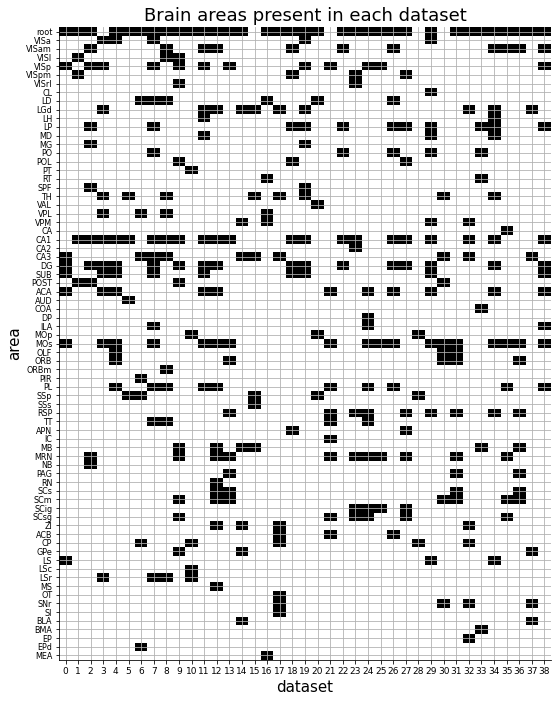

In [21]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# # Color the tick labels by region
# ytickobjs = plt.gca().get_yticklabels()
# ytickobjs[0].set_color("black")
# counter = 1
# for group, color in zip(brain_groups, region_colors):
#   for area in group:
#     ytickobjs[counter].set_color(color)
#     counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()